# Atividade de Redes Neurais

## Felipe Gibin

## 1. Introdução


O objetivo deste notebook é realizar a classificação estelar com base em suas características espectrais, dividindo-as em três categorias: estrelas, quasares e galáxias, uma atividade fundamental para a astronomia.

Para tal, usaremos o dataset SDSS17, disponível no kaggle pelo [link](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17), somado ao framework TensorFlow e bibliotecas do Python

### 1.1 O dataset

O dataset possui diversas features, dentre elas:

1. obj_ID = Identificador do Objeto, o valor único que identifica o objeto no catálogo de imagens usado pelo CAS.

2. alpha = Ângulo de Ascensão Reta (no período J2000).

3. delta = Ângulo de Declinação (no período J2000).

4. u = Filtro Ultravioleta no sistema fotométrico.

5. g = Filtro Verde no sistema fotométrico.

6. r = Filtro Vermelho no sistema fotométrico.

7. i = Filtro Infravermelho próximo no sistema fotométrico.

8. z = Filtro Infravermelho no sistema fotométrico.

9. run_ID = Número de execução usado para identificar a varredura específica.

10. rereun_ID = Número de reanálise para especificar como a imagem foi processada.

11. cam_col = Coluna da câmera para identificar a linha de varredura dentro da execução.

12. field_ID = Número do campo para identificar cada campo observado.

13. spec_obj_ID = ID único usado para objetos espectroscópicos ópticos (isso significa que 2 observações diferentes com o mesmo spec_obj_ID devem compartilhar a mesma classe de saída).

14. class = Classe do objeto (galáxia, estrela ou quasar).

15. redshift = Valor de desvio para o vermelho (redshift) baseado no aumento do comprimento de onda.

16. plate = ID da placa, identifica cada placa no SDSS.

17. MJD = Data Julian Modificada, usada para indicar quando uma determinada peça de dados do SDSS foi coletada.

18. fiber_ID = ID da fibra, que identifica a fibra que direcionou a luz para o plano focal em cada observação.

## 2. Carregamento dos dados e config inicial

In [28]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

#carrega dataset
df = pd.read_csv('star_classification.csv')
df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


## 3. EDA

### 3.1 Análise Inicial

In [ ]:
# Linhas e colunas do dataset
print(df.shape[0])
print(df.shape[1])

100000
18


In [29]:
# Análise inicial
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64


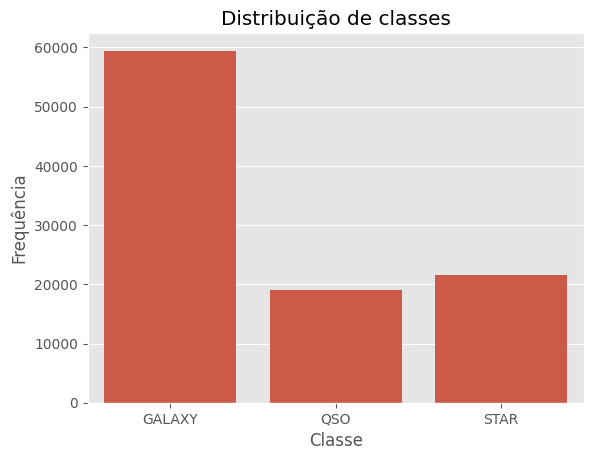

In [ ]:
import seaborn as sns

#Distribuição das classes
print(df['class'].value_counts())
sns.countplot(data=df, x='class')
plt.title("Distribuição de classes")
plt.xlabel("Classe", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.show()

### 3.2 Trata outliers

Devido à natureza astronômica das variáveis, que foge ao cotidiano e à familiaridade, é necessário ter mais cautela ao decidir tratar ou não os outliers. Pela análise inicial, observa-se que, em sua maioria, as features apresentam valores de média, máximo e mínimo relativamente próximos, o que sugere ausência de erros de medição. No entanto, há uma variável que foge desse padrão: redshift, cuja média e valor mínimo estão próximos de 0, mas o valor máximo chega a 7. Sendo assim, vamos tratar apenas os outliers dessa variável. Para tal, aplicaremos uma função de capping de (2-93%), tendo em vista que o upper range parece ter mais outliers.

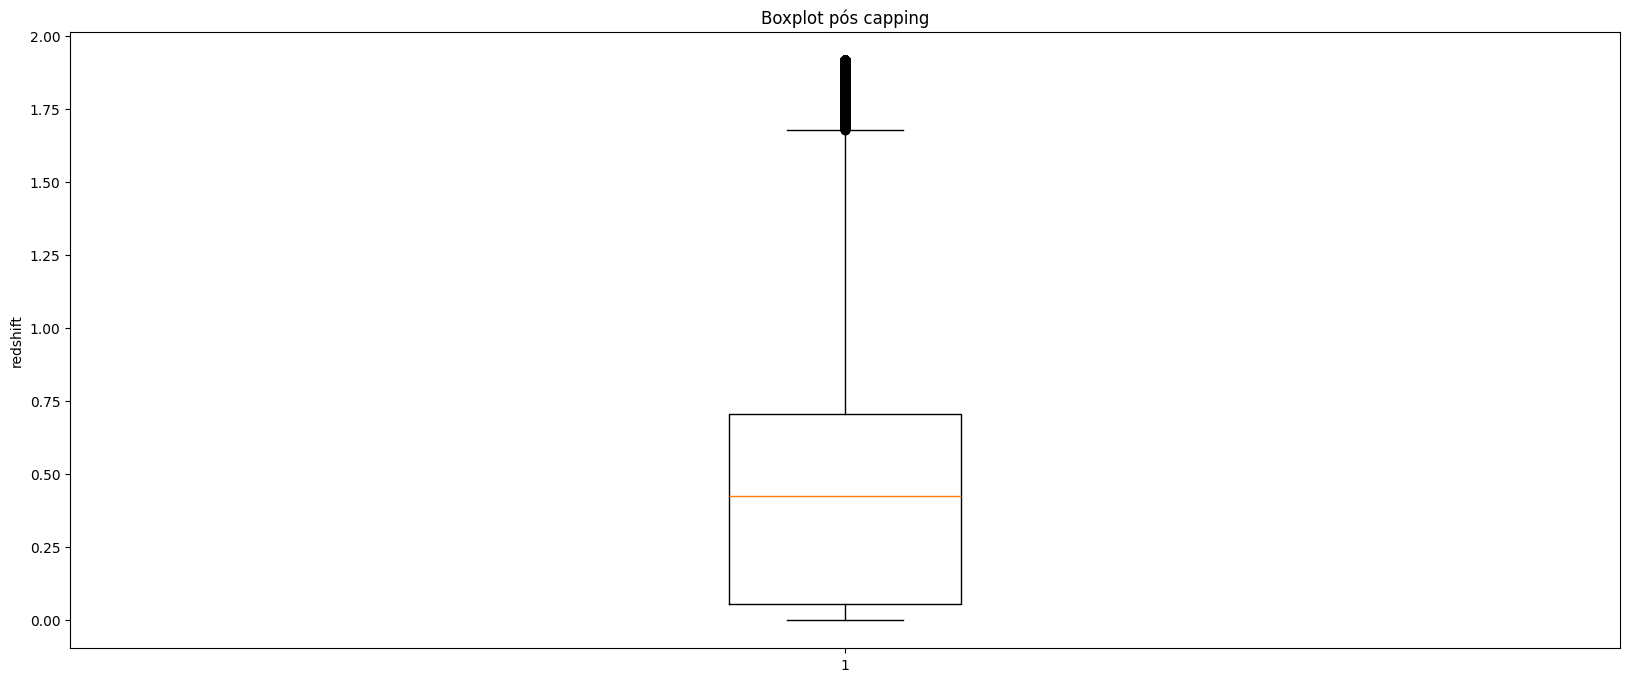

In [30]:
#funcao de capping (2-93%)
def cap_outliers(data, column):
    lower = data[column].quantile(0.02)
    upper = data[column].quantile(0.93)
    data[column] = np.clip(data[column], lower, upper)

cap_outliers(df,'redshift')

#Boxplot pós capping
plt.figure(figsize=(20, 8))
plt.boxplot(df['redshift'])
plt.title("Boxplot pós capping")
plt.ylabel("redshift")
plt.show()

### 3.3 Trata valores faltantes

In [31]:
#Soma os valores zero e NaN por coluna
NaN_values = df.isna().sum()

Zero_values = (df == 0).sum()

# Mostrar resultado
print("Contagem NaN por coluna:")
print(NaN_values)

print("\nContagem zeros por coluna:")
print(Zero_values)

Contagem NaN por coluna:
obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64

Contagem zeros por coluna:
obj_ID           0
alpha            0
delta            0
u                0
g                0
r                0
i                0
z                0
run_ID           0
rerun_ID         0
cam_col          0
field_ID         0
spec_obj_ID      0
class            0
redshift       412
plate            0
MJD              0
fiber_ID         0
dtype: int64


Observamos que 'redshift' possui 412 valores nulos, o que corresponde à 0,41% do total de entradas. Dado que essa feature é usada para determinar a distância e velocidade de corpos celestes em relação à Terra, a presença de valores nulos constitui um problema. Apesar da proporção baixa, vamos imputar essas linhas com a mediana para essa variável.

In [34]:
#Remove linha problemática
df = df[df['z'] != -9999].copy()

#Mediana de redshift
median_redshift = df['redshift'].median()

# Substitui valores 0 por NaN
df['redshift'] = df['redshift'].replace(0, np.nan)

#Preenche os valores NaN com a mediana
df['redshift'] = df['redshift'].fillna(median_redshift)

### 3.4 Distribuição dos dados numéricos

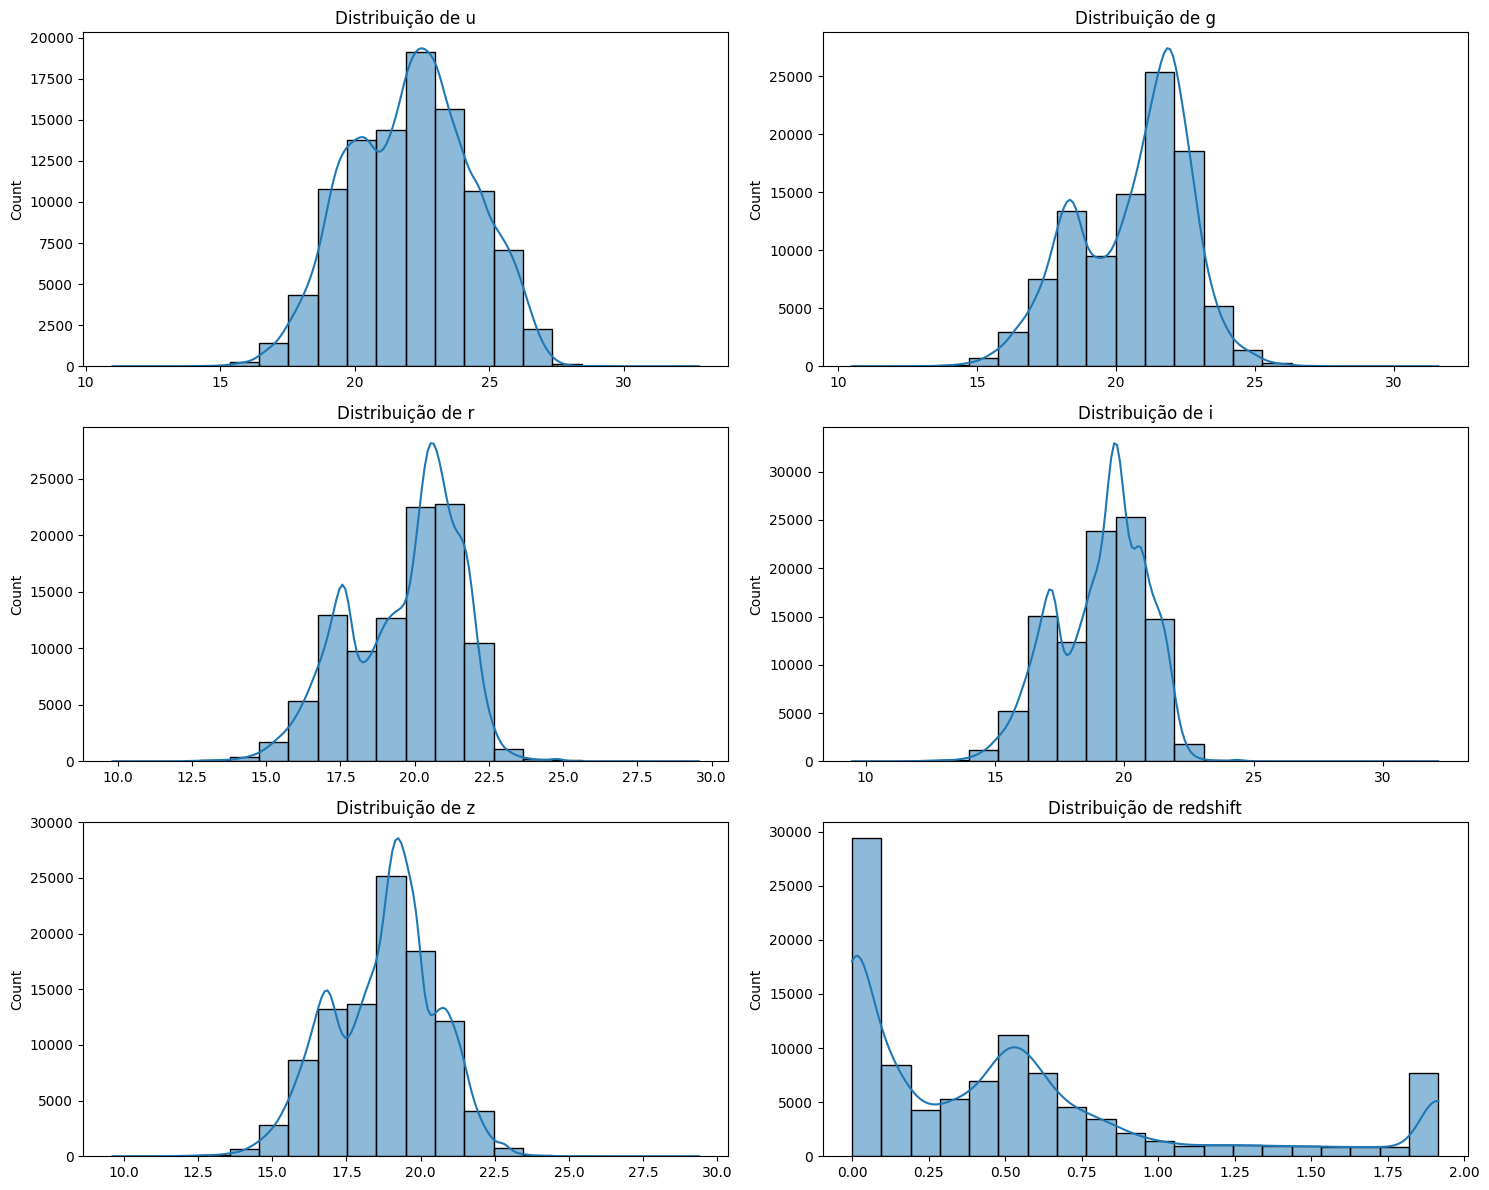

In [35]:
#Colunas relevantes
features = ['u', 'g', 'r', 'i', 'z', 'redshift']
plt.figure(figsize=(15, 12))

# Histogramas com curvas de densidade
for i, var in enumerate(features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[var], kde=True, bins=20)
    plt.title(f'Distribuição de {var}')
    plt.xlabel('')

plt.tight_layout()
plt.show()

Observe que excluímos diversas features dessa distribuição. A seguir, vamos explicar o motivo da exclusão de todas as features afetadas:

1. Todos os IDs. Foram excluídos por se tratarem de rótulos, sem valor preditivo

2. alpha, delta. Coordenadas espaciais do objeto, não interfere na classificação. Inclusive, se mantivéssemos as coordenadas, possívelmente incluiríamos um viés espacial à classificação.

3. cam_col. Metadado de observação, não é importante

4. plate, MJD. Informações sobre a placa de espectografia e data de observação, não influenciam na classificação.



## 4. Pré processamento dos dados

Para a tarefa de classificação, fica interessante codificar as classes em one hot, além de normalizar as features relevantes.

In [51]:
features = ['u', 'g', 'r', 'i', 'z', 'redshift']
X = df[features]
y = df['class']

#Codifica as classes em one hot
y = pd.get_dummies(y, drop_first=False) #drop_first = True é interessante para evitar colineridade, n se aplica aqui

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar apenas os dados de entrada
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 5. Treinando MLPs

Para essa tarefa, definimos um modelo do tipo MLP (Multilayer Perceptron). MLPs são redes neurais artificiais utilizadas em tarefas de classificação e regressão. Elas são compostas por camadas de neurônios interconectados, que transformam os dados de entrada em uma saída por meio de pesos ajustáveis. Esses pesos são atualizados com base no erro calculado pela função de perda, erro esse que é retropropagado por meio do algoritmo de backpropagation.

Neste caso, utilizamos como função de perda a `categorical cross entropy`, apropriada para problemas de classificação multiclasse em que as classes estão codificadas em formato one-hot. Além disso, a função de ativação `softmax` na camada de saída atribui, para cada classe, uma probabilidade da entrada pertencer a ela. Assim, o modelo realiza a classificação com base na maior probabilidade na saída. O otimizador `Adam` também foi usado, devido à sua adaptabilidade da taxa de aprendizado, que acelera a convergência. Outra técnica que usaremos é o Early Stopping, que interrompe o treinamento automaticamente caso a acurácia de validação não apresente melhora após um número definido de épocas (patience), evitando overfitting.

### 5.1 2 camadas escondidas, 512 neurônios por camada

In [ ]:
model_MLP1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),   #Camada escondida 1
    tf.keras.layers.Dense(512, activation='relu'),   #Camada escondida 2
    tf.keras.layers.Dense(3, activation='softmax')  #Camada de saída
])

model_MLP1.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.CategoricalCrossentropy(), #Função de perda
    metrics=['accuracy']
)


history1 = model_MLP1.fit(
    X_train,
    y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
)

# Avaliar modelo com dados de validação
loss, accuracy = model_MLP1.evaluate(X_test, y_test)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9228 - loss: 0.2811 - val_accuracy: 0.9582 - val_loss: 0.1323
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9649 - loss: 0.1129 - val_accuracy: 0.9662 - val_loss: 0.1144
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9672 - loss: 0.1053 - val_accuracy: 0.9682 - val_loss: 0.1072
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9680 - loss: 0.1015 - val_accuracy: 0.9694 - val_loss: 0.1013
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9704 - loss: 0.0966 - val_accuracy: 0.9704 - val_loss: 0.0994
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9709 - loss: 0.0950 - val_accuracy: 0.9714 - val_loss: 0.0986
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9724 - loss: 0.0941 - val_accuracy: 0.9703 - val_loss: 0.1037
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9736 - loss: 0.0889 -

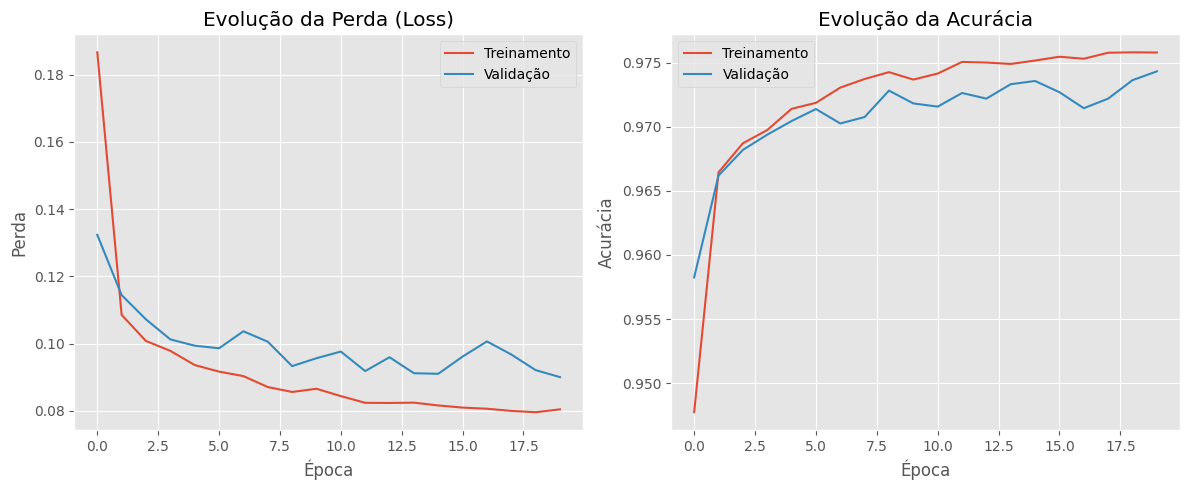

In [ ]:
#Evolução das curvas de perda e acurácia

plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Treinamento')
plt.plot(history1.history['val_loss'], label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Treinamento')
plt.plot(history1.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


O modelo não apresenta overfitting. Os valores de perda e acurácia se mantém próximos e com flutuações normais. Pelo número grande de neurônios por camada (512) o modelo se mostra complexo o suficiente para representar bem o problema, contudo seria interessante diminuir o número de neurônios, para manter a performance enquanto reduz a complexidade do modelo, visto que o problema atual não é tão complexo.

### 5.2 8 camadas escondidas, 16 neurônios por camada

In [ ]:
model_MLP2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),   #Camada escondida 1
    tf.keras.layers.Dense(16, activation='relu'),   #Camada escondida 2
    tf.keras.layers.Dense(16, activation='relu'),   #Camada escondida 3
    tf.keras.layers.Dense(16, activation='relu'),   #Camada escondida 4
    tf.keras.layers.Dense(16, activation='relu'),   #Camada escondida 5
    tf.keras.layers.Dense(16, activation='relu'),   #Camada escondida 6
    tf.keras.layers.Dense(16, activation='relu'),   #Camada escondida 7
    tf.keras.layers.Dense(16, activation='relu'),   #Camada escondida 8
    tf.keras.layers.Dense(3, activation='softmax')  #Camada de saída
])

model_MLP2.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.CategoricalCrossentropy(), #Função de perda
    metrics=['accuracy']
)

history2 = model_MLP2.fit(
    X_train,
    y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
)

# Avaliar modelo com dados de validação
loss, accuracy = model_MLP2.evaluate(X_test, y_test)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8748 - loss: 0.3352 - val_accuracy: 0.9634 - val_loss: 0.1223
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9641 - loss: 0.1330 - val_accuracy: 0.9668 - val_loss: 0.1123
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9673 - loss: 0.1093 - val_accuracy: 0.9674 - val_loss: 0.1123
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9673 - loss: 0.1071 - val_accuracy: 0.9691 - val_loss: 0.1021
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9684 - loss: 0.1013 - val_accuracy: 0.9668 - val_loss: 0.1105
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9683 - loss: 0.1019 - val_accuracy: 0.9702 - val_loss: 0.0970
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9702 - loss: 0.0983 - val_accuracy: 0.9582 - val_loss: 0.1372
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9705 - loss: 0.0958 

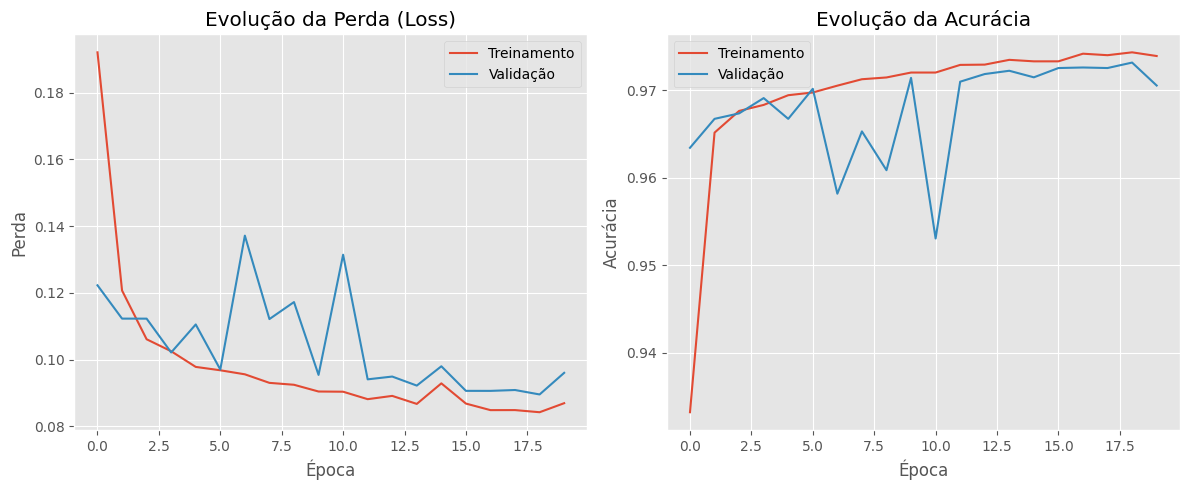

In [ ]:
#Evolução das curvas de perda e acurácia

plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Treinamento')
plt.plot(history2.history['val_loss'], label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Treinamento')
plt.plot(history2.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


A quantidade excessiva de camadas, todas com poucos neurônios (16) parece criar uma complexidade que gera flutuações nos valores da perda e acurácia. Esse comportamento pode se dar pela presença de overfitting leve, em que o modelo aprende bem os pesos de um determinado batch, e no próximo acaba não indo tão bem. Testamos esse caso extremo de camadas e neurônios afim de confirmar essa hipótese, portanto sugere-se uma escolha de arquitetura da rede mais convencional.

### 5.3 Variando épocas

In [ ]:
model_MLP3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),   #Camada escondida 1
    tf.keras.layers.Dense(64, activation='relu'),   #Camada escondida 2
    tf.keras.layers.Dense(3, activation='softmax')  #Camada de saída
])

model_MLP3.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.CategoricalCrossentropy(), #Função de perda
    metrics=['accuracy']
)


# 3 épocas
history3 = model_MLP3.fit(
    X_train,
    y_train,
    epochs=3,
    validation_split=0.2,
    batch_size=32,
)

# Avaliar modelo com dados de validação
loss, accuracy = model_MLP3.evaluate(X_test, y_test)

Epoch 1/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8981 - loss: 0.3126 - val_accuracy: 0.9636 - val_loss: 0.1261
Epoch 2/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9626 - loss: 0.2564 - val_accuracy: 0.9654 - val_loss: 0.1129
Epoch 3/3
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9668 - loss: 0.1331 - val_accuracy: 0.9669 - val_loss: 0.1066
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9684 - loss: 0.1019


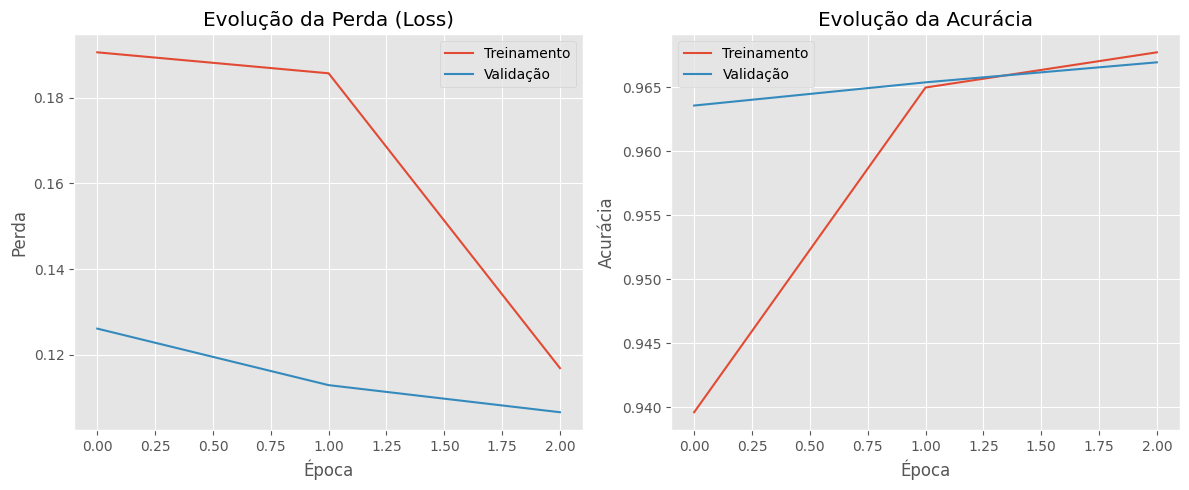

In [ ]:
#Evolução das curvas de perda e acurácia

plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Treinamento')
plt.plot(history3.history['val_loss'], label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'], label='Treinamento')
plt.plot(history3.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


O modelo apresenta indícios claros de underfitting, em que o modelo não consegue generalizar os padrões presentes no dataset, nesse caso pelo número muito pequeno de épocas (3). É preciso aumentar o número de épocas. Testaremos o outro extremo para essa escolha agora.

In [ ]:
model_MLP4 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),   #Camada escondida 1
    tf.keras.layers.Dense(64, activation='relu'),   #Camada escondida 2
    tf.keras.layers.Dense(3, activation='softmax')  #Camada de saída
])

model_MLP4.compile(
    optimizer=tf.keras.optimizers.Adam(),   #Otimizador Adam
    loss=tf.keras.losses.CategoricalCrossentropy(), #Função de perda
    metrics=['accuracy']
)


# 50 épocas
history4 = model_MLP4.fit(
    X_train,
    y_train,
    epochs=50,
    validation_split=0.2,
    batch_size=32,
)

# Avaliar modelo com dados de validação
loss, accuracy = model_MLP4.evaluate(X_test, y_test)

Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8965 - loss: 0.3287 - val_accuracy: 0.9628 - val_loss: 0.1312
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9626 - loss: 0.1364 - val_accuracy: 0.9661 - val_loss: 0.1104
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9669 - loss: 0.1066 - val_accuracy: 0.9671 - val_loss: 0.1044
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9686 - loss: 0.1005 - val_accuracy: 0.9686 - val_loss: 0.1017
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9699 - loss: 0.0969 - val_accuracy: 0.9694 - val_loss: 0.1005
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9705 - loss: 0.0947 - val_accuracy: 0.9681 - val_loss: 0.1038
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9710 - loss: 0.0924 - val_accuracy: 0.9684 - val_loss: 0.1044
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9719 - loss: 0.0907 

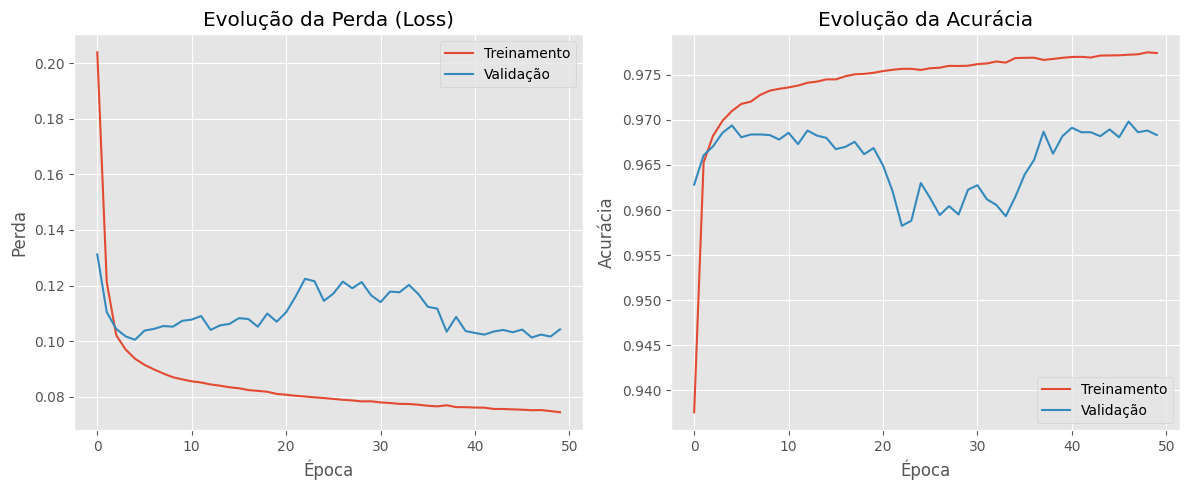

In [ ]:
#Evolução das curvas de perda e acurácia

plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'], label='Treinamento')
plt.plot(history4.history['val_loss'], label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(history4.history['accuracy'], label='Treinamento')
plt.plot(history4.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


Contrário ao último modelo, aqui obtemos indícios claros de overfitting. A distância entre a perda e acurácia de treinamento e validação indica que o modelo aprende bem os dados de treinamento, mas não generaliza para outros dados do dataset presentes na validação. Recomenda-se usar um número menor de épocas e aplicar técnicas de regularização.

### 5.4 Variando learning rate

In [ ]:
model_MLP5 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),   #Camada escondida 1
    tf.keras.layers.Dense(64, activation='relu'),   #Camada escondida 2
    tf.keras.layers.Dense(3, activation='softmax')  #Camada de saída
])

model_MLP5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
    loss=tf.keras.losses.CategoricalCrossentropy(), #Função de perda
    metrics=['accuracy']
)

history5 = model_MLP5.fit(
    X_train,
    y_train,
    epochs=15,
    validation_split=0.2,
    batch_size=32,
)

# Avaliar modelo com dados de validação
loss, accuracy = model_MLP5.evaluate(X_test, y_test)

Epoch 1/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.3392 - loss: 1.1166 - val_accuracy: 0.3679 - val_loss: 1.0928
Epoch 2/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.3815 - loss: 1.0862 - val_accuracy: 0.5113 - val_loss: 1.0640
Epoch 3/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5724 - loss: 1.0579 - val_accuracy: 0.5986 - val_loss: 1.0372
Epoch 4/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6361 - loss: 1.0315 - val_accuracy: 0.6830 - val_loss: 1.0123
Epoch 5/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6932 - loss: 1.0071 - val_accuracy: 0.7061 - val_loss: 0.9891
Epoch 6/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7110 - loss: 0.9842 - val_accuracy: 0.7171 - val_loss: 0.9670
Epoch 7/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7200 - loss: 0.9623 - val_accuracy: 0.7234 - val_loss: 0.9458
Epoch 8/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7262 - loss: 0.9413 

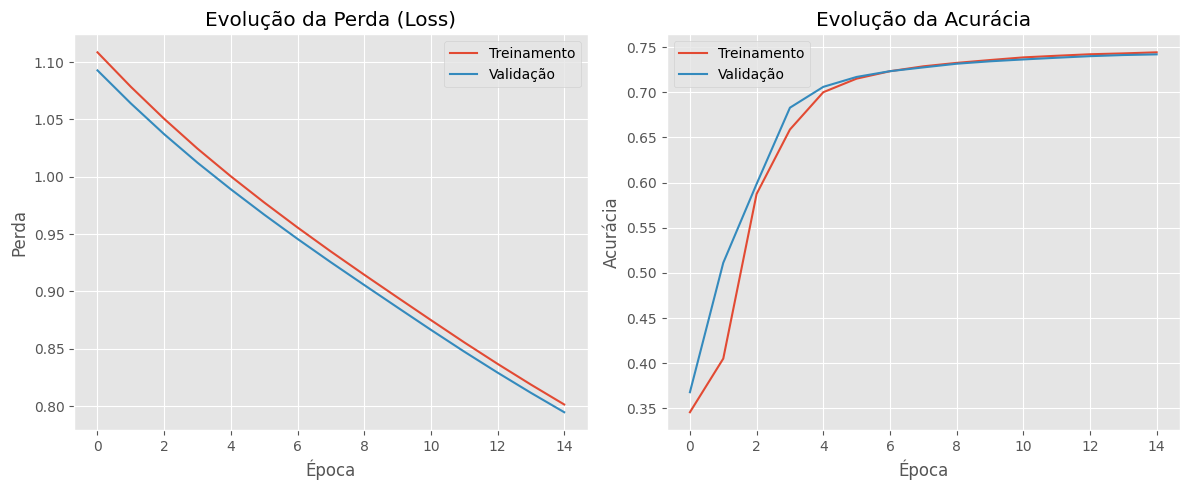

In [ ]:
#Evolução das curvas de perda e acurácia

plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(history5.history['loss'], label='Treinamento')
plt.plot(history5.history['val_loss'], label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(history5.history['accuracy'], label='Treinamento')
plt.plot(history5.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


Aqui, o learning rate extremamente baixo impede o modelo de aprender efetivamente, gerando o underfitting. A convergência se torna extremamente lenta visto que a cada passagem pela rede, os pesos são pouco alterados, e o modelo não tem tempo suficiente para aprender os padrões dos dados.

In [ ]:
model_MLP6 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),   #Camada escondida 1
    tf.keras.layers.Dense(64, activation='relu'),   #Camada escondida 2
    tf.keras.layers.Dense(3, activation='softmax')  #Camada de saída
])

model_MLP6.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.2),
    loss=tf.keras.losses.CategoricalCrossentropy(), #Função de perda
    metrics=['accuracy']
)

history6 = model_MLP5.fit(
    X_train,
    y_train,
    epochs=15,
    validation_split=0.2,
    batch_size=32,
)

# Avaliar modelo com dados de validação
loss, accuracy = model_MLP6.evaluate(X_test, y_test)

Epoch 1/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7427 - loss: 0.7910 - val_accuracy: 0.7426 - val_loss: 0.7784
Epoch 2/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7435 - loss: 0.7749 - val_accuracy: 0.7431 - val_loss: 0.7629
Epoch 3/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7440 - loss: 0.7596 - val_accuracy: 0.7434 - val_loss: 0.7480
Epoch 4/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7441 - loss: 0.7449 - val_accuracy: 0.7436 - val_loss: 0.7337
Epoch 5/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7443 - loss: 0.7307 - val_accuracy: 0.7437 - val_loss: 0.7199
Epoch 6/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7446 - loss: 0.7170 - val_accuracy: 0.7442 - val_loss: 0.7064
Epoch 7/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7457 - loss: 0.7037 - val_accuracy: 0.7490 - val_loss: 0.6935
Epoch 8/15
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7539 - loss: 0.6908

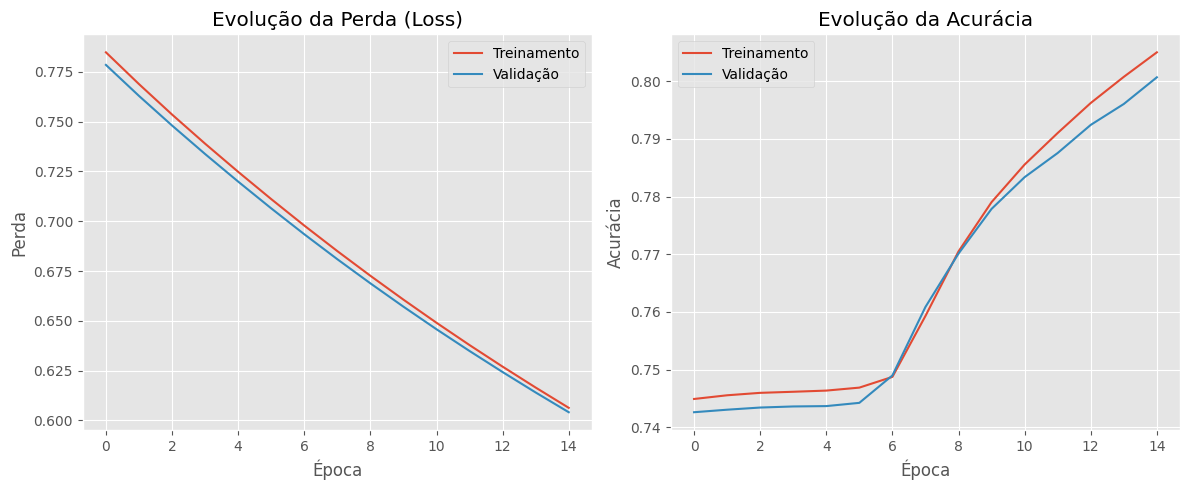

In [ ]:
#Evolução das curvas de perda e acurácia

plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(history6.history['loss'], label='Treinamento')
plt.plot(history6.history['val_loss'], label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(history6.history['accuracy'], label='Treinamento')
plt.plot(history6.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


Observamos um overfitting marcante. A acurácia de teste extremamente baixa(14%), indica que o modelo não consegue generalizar para dados nunca vistos antes. Isso se deve pelo learning rate muiot alto (0.2), que gera atualizações de pesos instáveis e dificulta a convergência.

### 5.5 Técnicas de regularização

In [ ]:
#Regularização L2 + Early Stopping
model_MLP7 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.8)),   #regularização L2
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.8)),   #regularização L2
    tf.keras.layers.Dense(3, activation='softmax')  #Camada de saída
])

model_MLP7.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(), #Função de perda
    metrics=['accuracy']
)

#Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)

history7 = model_MLP7.fit(
    X_train,
    y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    callbacks=[es]
)

# Avaliar modelo com dados de validação
loss, accuracy = model_MLP7.evaluate(X_test, y_test)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.6117 - loss: 8.8951 - val_accuracy: 0.5926 - val_loss: 0.9579
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5962 - loss: 0.9547 - val_accuracy: 0.5926 - val_loss: 0.9586
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5947 - loss: 0.9560 - val_accuracy: 0.5926 - val_loss: 0.9578
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5970 - loss: 0.9534 - val_accuracy: 0.5926 - val_loss: 0.9575
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5943 - loss: 0.9560


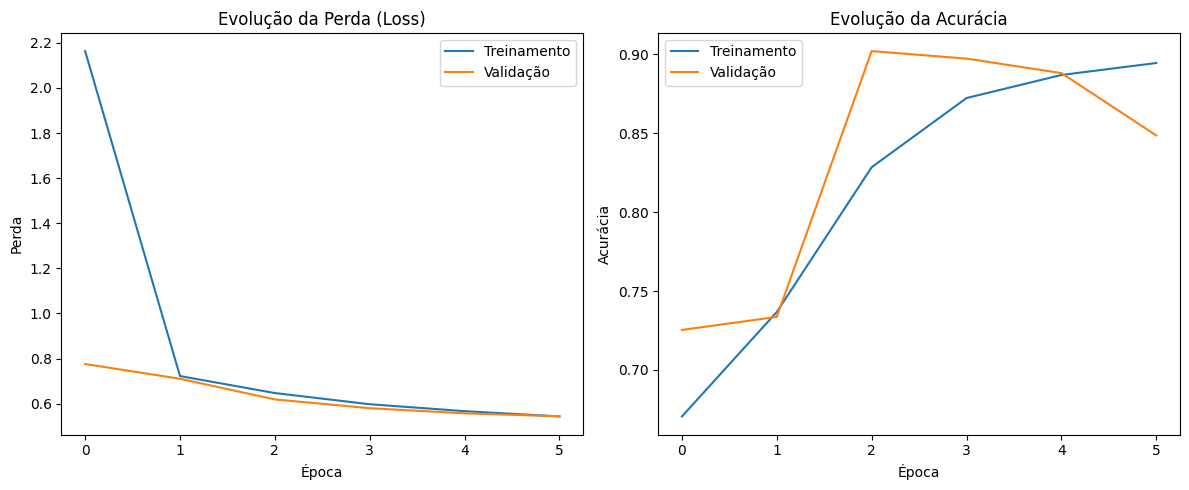

In [ ]:
#Evolução das curvas de perda e acurácia

plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(history7.history['loss'], label='Treinamento')
plt.plot(history7.history['val_loss'], label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(history7.history['accuracy'], label='Treinamento')
plt.plot(history7.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


Embora a acurácia de teste tenha sido relativamente alta, observamos que o modelo não generaliza muito bem de novo, o que pode parecer contraditório visto que usamos regularização L2. Essa regularização adiciona uma penalidade à função de perda proporcional ao quadrado dos pesos do modelo, ou seja, ela penaliza fortemente pesos grandes. Uma explicação para a baixa generalização do modelo é que o parâmetro de regularização passado foi muito alto (0.5), e que a regularização foi usada em ambas as camadas escondidas, o que penalizou demais os pesos da rede e a impediu de classificar os dados de forma ótima. Além disso, vemos que somente 4 épocas da rede foram executadas, oq indica que a regularização pune os pesos ao ponto que a rede não consegue melhorá-los antes do early stopping. Escolhi usar esse exemplo para demonstrar que a regularização nem sempre é positiva. Ela pode penalizar demais o modelo, o impedindo de aprender de forma ótima os pesos. Assim, embora a regularização seja uma aliada para lidar com o overfitting, é preciso tomar cuidado e usá-la com cautela.

In [54]:
#Dropout + Early Stopping
model_MLP8 = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),                   #Camada de Dropout
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),                   #Camada de Dropout
    tf.keras.layers.Dense(3, activation='softmax')  #Camada de saída
])

model_MLP8.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(), #Função de perda
    metrics=['accuracy']
)

#Early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)

history8 = model_MLP8.fit(
    X_train,
    y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    callbacks=[es]
)

# Avaliar modelo com dados de validação
loss, accuracy = model_MLP8.evaluate(X_test, y_test)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8658 - loss: 0.3522 - val_accuracy: 0.9581 - val_loss: 0.1408
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9579 - loss: 0.1344 - val_accuracy: 0.9654 - val_loss: 0.1138
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9622 - loss: 0.1208 - val_accuracy: 0.9669 - val_loss: 0.1151
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9651 - loss: 0.1158 - val_accuracy: 0.9632 - val_loss: 0.1185
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9674 - loss: 0.1055 - val_accuracy: 0.9689 - val_loss: 0.1044
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9688 - loss: 0.1017 - val_accuracy: 0.9703 - val_loss: 0.0959
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9686 - loss: 0.1012 - val_accuracy: 0.9709 - val_loss: 0.0992
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9710 - loss: 0.0976

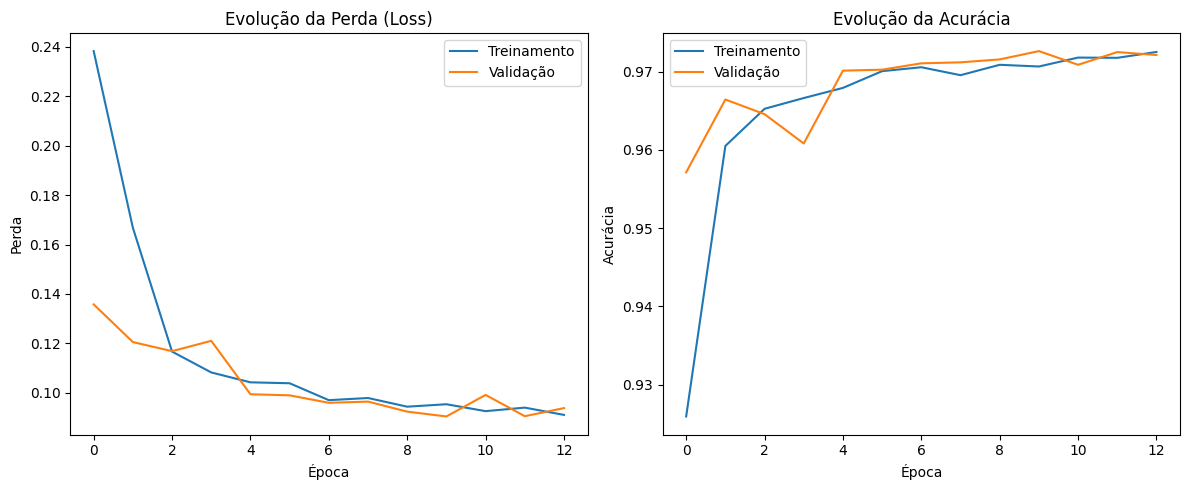

In [ ]:
#Evolução das curvas de perda e acurácia

plt.figure(figsize=(12, 5))

# Curva de perda
plt.subplot(1, 2, 1)
plt.plot(history8.history['loss'], label='Treinamento')
plt.plot(history8.history['val_loss'], label='Validação')
plt.title('Evolução da Perda (Loss)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Curva de acurácia
plt.subplot(1, 2, 2)
plt.plot(history8.history['accuracy'], label='Treinamento')
plt.plot(history8.history['val_accuracy'], label='Validação')
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


Na regularização por Dropout, desligamos aleatoriamente neurônios durante o treinamento, forçando a rede a não depender de caminhos específicos. Isso reduz o overfitting, pois evita que a rede desenvolva demais um caminho específico durante o treinamento. Nesse modelo, observamos que não houve nem overfitting nem underfitting. O modelo foi capaz de generalizar bem para o conjunto de teste, além de manter acurácias semelhantes entre treinamento e validação. Além disso, é possível notar que não treinamos durante as 20 épocas, o early stopping parou o treinamento na 13a, o que indica que se continuássemos veríamos um overfitting.

## 6. Melhor modelo

A decisão de qual é o melhor modelo fica entre o `model_MLP1` e `model_MLP8`. Contudo, tendo em vista que o modelo 8 alcança desempenho similar ao modelo 1, mas com 12.5% dos neurônios deste, a escolha vai para o modelo com Dropout.

### 6.1 Matriz de confusão

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


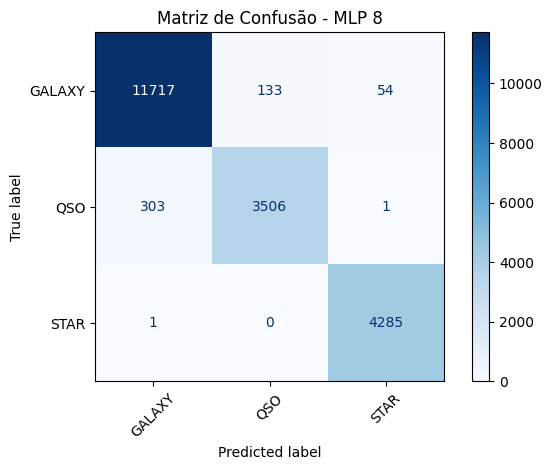

In [57]:
# Fazer predições
y_pred_probs = model_MLP8.predict(X_test)

# Obter as classes previstas (índice da maior probabilidade)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Obter as classes reais (índice da classe 1 no one-hot)
y_true_classes = np.argmax(y_test.values, axis=1)

# Nomes das classes (pegando da coluna original)
class_names = y_test.columns.tolist()

# Criar matriz de confusão
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Exibir a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusão - MLP 8")
plt.tight_layout()
plt.show()

A matriz de confusão reflete a ótima generalização do modelo. O Recall e Precisão do modelo são excelentes, andando lado a lado com a acurácia. Há uma pequena confusão entre quasares e galáxias, que pode ser explicada pelo fato que quasares são núcleos luminosos galáticos, podendo parecer-se de certa forma com galáxias em seu espectro.

### 6.2 Curva ROC

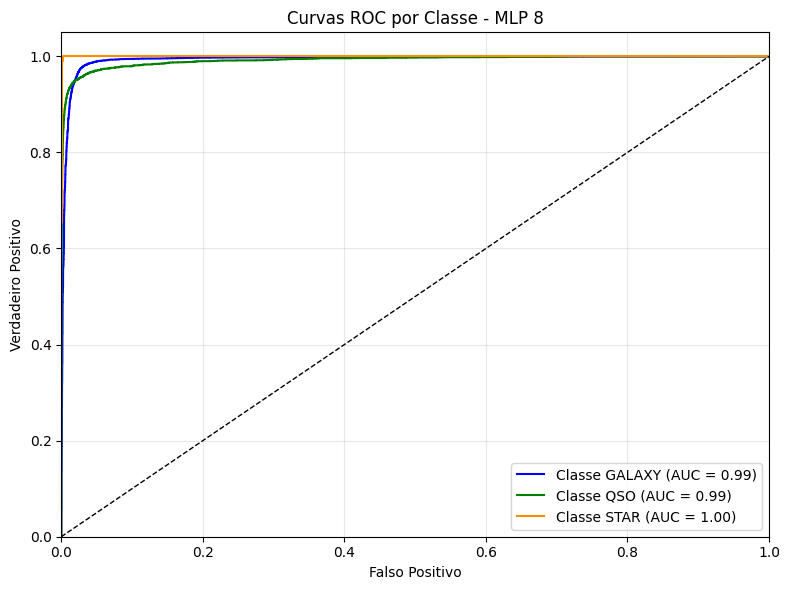

In [61]:
# Classes e cores
class_names = y_test.columns.tolist()
n_classes = len(class_names)
colors = ['blue', 'green', 'darkorange']

# Calcular curva ROC e AUC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()

# As previsões já estão em y_pred_probs
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test.values[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot das curvas
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i],
             label=f'Classe {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Linha aleatória
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curvas ROC por Classe - MLP 8')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


A curva ROC (Receiver Operating Characteristic) é um gráfico que ilustra a performance de um modelo de classificação. Ela é o plot da taxa de verdadeiros positivos (TPR) pela taxa de falsos positivos (FPR), em que quanto maior a área sob o gráfico (AUC), melhor é a capacidade de classificação do modelo. Ao observar a ROC de cada classe do nosso problema, vemos que ela novamente reflete a ótima capacidade de classificação do mesmo. A AUC das classes aproxima-se muito do classificador ideal (AUC = 1), em que a classe `STAR` é tão próxima de 1 que a biblioteca aproxima sua AUC para 1.

## 7. Conclusões

Com base nas métricas de avaliação e nas curvas ROC, concluímos que o modelo apresenta excelente desempenho na tarefa de classificação. As altas AUCs, próximas de 1 para todas as classes, somadas aos excelentes índices de recall, precisão e accuracy indicam uma forte capacidade de distinção das classes. Isso demonstra que o modelo está bem ajustado e generaliza bem sobre os dados de teste, o que não surpreende visto que esse é um problema relativamente simples e que favorece o uso de perceptrons multicamadas por causa da natureza dos dados, que são bem estruturados e se separam bem em um espaço não linear. A capacidade do MLP de capturar essa não linearidade, somada à estratégias como dropout e early stopping, contribuiu para evitar overfitting e alcançar um equilíbrio entre desempenho e simplicidade do modelo.